## Modelling LSTM
Spelling error: 'compound' is mistakenly written as 'compund' and I noticed it after complete coding.

In [5]:
print('STOCK PREDICTION USING RNN LSTM')
import numpy as np
import pandas as pd
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)

%matplotlib inline

STOCK PREDICTION USING RNN LSTM


### Plotting the data

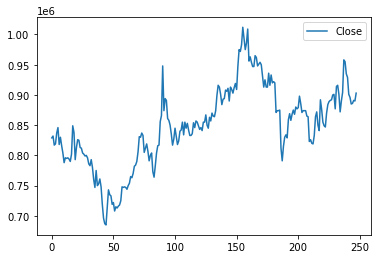

<Figure size 432x288 with 0 Axes>

In [6]:
data_csv = pd.read_csv('final_data_new.csv')

data_csv[['Close']].plot()
plt.show()
plt.clf()

In [7]:
data_csv

Date  compound    neg    neu    pos      Open      High       Low  \
0    20210104    0.9999  0.043  0.807  0.149  819000.0  838000.0  804000.0   
1    20210105    0.9999  0.044  0.796  0.160  825000.0  834000.0  818000.0   
2    20210106    0.9998  0.054  0.807  0.140  828000.0  837000.0  816000.0   
3    20210107    0.9998  0.044  0.793  0.163  824000.0  824000.0  816000.0   
4    20210108    0.9995  0.065  0.793  0.142  821000.0  840000.0  815000.0   
..        ...       ...    ...    ...    ...       ...       ...       ...   
243  20211224    0.9993  0.033  0.814  0.153  896000.0  903000.0  885000.0   
244  20211227    0.9997  0.053  0.794  0.153  885000.0  897000.0  885000.0   
245  20211228    0.9994  0.051  0.818  0.132  891000.0  893000.0  883000.0   
246  20211229    0.9996  0.055  0.805  0.139  899000.0  905000.0  884000.0   
247  20211230    0.9997  0.082  0.743  0.175  959000.0  959000.0  896000.0   

        Close  Volume  
0    829000.0  182864  
1    832000.0  119911  
2    817000.0  145873  
3    819000.0  116480  
4    837000.0  263860  
..        ...     ...  
243  885000.0   49424  
244  886000.0   57185  
245  891000.0   90833  
246  890000.0   71560  
247  903000.0  173007  

[248 rows x 10 columns]

### Calculating the length of data to use

In [8]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data_csv)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data_csv)
print("total_data:", total_data)

total_data: 248


### Arranging the data

In [9]:
start = total_data - data_to_use

# Currently doing prediction only for 1 step ahead
steps_to_predict = 1

#close, compund, neg, neu, pos, open, high, low, volume
# Order -> 8,1,2,3,4,5,6,7,9
yt = data_csv.iloc[start:total_data,8] #close
yt1 = data_csv.iloc[start:total_data,1] #compund
yt2 = data_csv.iloc[start:total_data,2] #neg
yt3 = data_csv.iloc[start:total_data,3] #neu
yt4 = data_csv.iloc[start:total_data,4] #pos
yt5 = data_csv.iloc[start:total_data,5] #open
yt6 = data_csv.iloc[start:total_data,6] #high
yt7 = data_csv.iloc[start:total_data,7] #low
vt = data_csv.iloc[start:total_data,9] #volume

print("yt head (close) :")
print(yt.head())

yt head (close) :
1    832000.0
2    817000.0
3    819000.0
4    837000.0
5    846000.0
Name: Close, dtype: float64


### Shifting the data by 1

In [10]:
#shift next day close and next day compund
yt_ = yt.shift(-1) #shifted close
yt1_ = yt1.shift(-1) #shifted compund

#taking only: close, next_close, compund, next_compund, volume, open, high, low
data = pd.concat([yt, yt_, yt1, yt1_, vt, yt5, yt6, yt7], axis=1)
data.columns = ['yt', 'yt_', 'yt1', 'yt1_','vt', 'yt5', 'yt6', 'yt7']

data = data.dropna()
     
print(data[:10])

          yt       yt_     yt1    yt1_      vt       yt5       yt6       yt7
1   832000.0  817000.0  0.9999  0.9998  119911  825000.0  834000.0  818000.0
2   817000.0  819000.0  0.9998  0.9998  145873  828000.0  837000.0  816000.0
3   819000.0  837000.0  0.9998  0.9995  116480  824000.0  824000.0  816000.0
4   837000.0  846000.0  0.9995  0.9998  263860  821000.0  840000.0  815000.0
5   846000.0  818000.0  0.9998  0.9998  560123  841000.0  883000.0  824000.0
6   818000.0  830000.0  0.9998  0.9998  289113  847000.0  862000.0  806000.0
7   830000.0  816000.0  0.9998  0.9998  207744  814000.0  832000.0  802000.0
8   816000.0  804000.0  0.9998  0.9987  163631  828000.0  828000.0  810000.0
9   804000.0  788000.0  0.9987  0.9999  142061  820000.0  824000.0  804000.0
10  788000.0  796000.0  0.9999  0.9998  163860  793000.0  811000.0  786000.0


### Separating data into x and y
**Approach:** Training the machine using ***compund, close price, and next_compund*** to predict ***next_close price***.

In [11]:
# target variable - closed price
# after shifting
y = data['yt_'] #next_close

# close, compund, next_compund, volume, open, high, low   
cols = ['yt', 'yt1', 'yt1_', 'vt', 'yt5', 'yt6', 'yt7']
x = data[cols]

### Preprocessing

In [12]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

### Train Test Split

In [13]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

### RNN LSTM Model

In [33]:
batch_size = 32
nb_epoch = 100
neurons = 25
dropout = 0.1

seed = 2016
np.random.seed(seed)

model = Sequential()
# model.add(LSTM(neurons, return_sequences=True, activation='tanh', inner_activation='hard_sigmoid', input_shape=(len(cols), 1)))
# model.add(Dropout(dropout))
# model.add(LSTM(neurons, return_sequences=True,  activation='tanh'))
# model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

# model.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))
model.add(Activation('tanh'))

# print(model.summary())

model.compile(loss='mean_squared_error' , optimizer='RMSprop')
model.fit(X_train, y_train, batch_size=batch_size, verbose=1, validation_split=0.2)
# model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.2)

5/5 [==============================] - 1s 42ms/step - loss: 0.1963 - val_loss: 0.2269


### Score Calculation

In [34]:
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
print("in train MSE = ", round( score_train ,4)) 
print("in test MSE = ", score_test )

48/48 [==============================] - 0s 920us/step - loss: 0.0826
in train MSE =  0.1994
in test MSE =  0.08260124176740646


### Saving model

In [35]:
model_json = model.to_json()
with open("model_rms100e_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_rms100e_new.h5")
print("Saved model to disk")

Saved model to disk


### Predicting on unseen data

Inputs: (None, 7, 1)
Outputs: (None, 25)
Actual input: (48, 7)
Actual output: (48, 1)
prediction data:
[723993.75]
actual data
[[2.34443220e+16 9.99999965e-01 9.99999983e-01 9.64571244e+15
  2.41667533e+16 2.61558946e+16 2.09534263e+16]
 [2.34977865e+16 9.99999983e-01 9.99999983e-01 1.24163764e+16
  2.41943093e+16 2.64534571e+16 2.11724503e+16]
 [2.40056992e+16 9.99999983e-01 9.99999983e-01 2.13408051e+16
  2.46627613e+16 2.70188259e+16 2.17321783e+16]
 [2.36849122e+16 9.99999983e-01 9.99999965e-01 1.85281136e+16
  2.50209893e+16 2.70188259e+16 2.15618263e+16]
 [2.32839285e+16 9.99999965e-01 9.99999965e-01 1.34643943e+16
  2.46903173e+16 2.67510196e+16 2.10751063e+16]
 [2.33641252e+16 9.99999965e-01 9.99999965e-01 9.58352130e+15
  2.41667533e+16 2.62749196e+16 2.11724503e+16]
 [2.33641252e+16 9.99999965e-01 9.99999965e-01 8.84402977e+15
  2.39187493e+16 2.62749196e+16 2.11237783e+16]
 [2.33641252e+16 9.99999965e-01 9.99999965e-01 9.21547607e+15
  2.41391973e+16 2.61856509e+16 2.0977762

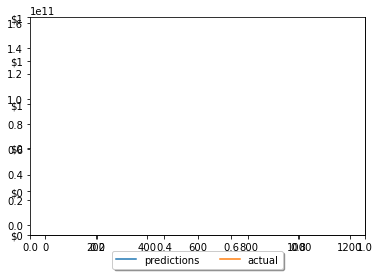

<Figure size 432x288 with 0 Axes>

In [45]:
pred = model.predict(X_test) 
# pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))
pred = scaler_y.inverse_transform(np.array(pred).reshape((1200, 1)))

prediction_data = pred[-1]     

print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

print ("actual data")
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
print (X_test)

# #########################################################################
'''Plotting'''
plt.plot(pred, label="predictions")

y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len( y_test), 1)))
plt.plot([row[0] for row in y_test], label="actual")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
plt.show()
plt.clf()
